The aim of this notebook is to be a comprehensive starting point for anyone interested and/or participating the OSIC Pulmonary Fibrosis Progression competition.
It will focus on analyzing the OSIC training set provided for the competition, including:
* Tabular clinical data
* CT Lung Scans and Features extracted from the scans

(As this is the first time I'm posting an EDA here, any advice/suggestions regarding the analysis itself, the charts used or the coding, is welcome).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # statistical data visualization
import plotly.express as px
import plotly.graph_objects as go # interactive plots

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


# Dataframe uniqueness/quality check

Let's start by checking how many data points there are, and if anything is missing.

In [3]:
print('Number of data points: ' + str(len(train_df)))
print('----------------------')

for col in train_df.columns:
    print('{} : {} unique values, {} missing.'.format(col, 
                                                          str(len(train_df[col].unique())), 
                                                          str(train_df[col].isna().sum())))

Number of data points: 1549
----------------------
Patient : 176 unique values, 0 missing.
Weeks : 112 unique values, 0 missing.
FVC : 1202 unique values, 0 missing.
Percent : 1536 unique values, 0 missing.
Age : 34 unique values, 0 missing.
Sex : 2 unique values, 0 missing.
SmokingStatus : 3 unique values, 0 missing.


This dataset will contain a single entry for each patient, leaving only their personal information, to have a clearer and more accurate representation of the distribution of these categorical variables.
It will also include how many times a patient appears in the dataset, to observe how many visits each one has done.

In [4]:
unique_patient_df = train_df.drop(['Weeks', 'FVC', 'Percent'], axis=1).drop_duplicates().reset_index(drop=True)
unique_patient_df['# visits'] = [train_df['Patient'].value_counts().loc[pid] for pid in unique_patient_df['Patient']]

print('Number of data points: ' + str(len(unique_patient_df)))
print('----------------------')

for col in unique_patient_df.columns:
    print('{} : {} unique values, {} missing.'.format(col, 
                                                          str(len(unique_patient_df[col].unique())), 
                                                          str(unique_patient_df[col].isna().sum())))
unique_patient_df.head()

Number of data points: 176
----------------------
Patient : 176 unique values, 0 missing.
Age : 34 unique values, 0 missing.
Sex : 2 unique values, 0 missing.
SmokingStatus : 3 unique values, 0 missing.
# visits : 5 unique values, 0 missing.


,Patient,Age,Sex,SmokingStatus,# visits
0,ID00007637202177411956430,79,Male,Ex-smoker,9
1,ID00009637202177434476278,69,Male,Ex-smoker,9
2,ID00010637202177584971671,60,Male,Ex-smoker,9
3,ID00011637202177653955184,72,Male,Ex-smoker,9
4,ID00012637202177665765362,65,Male,Never smoked,9


# 1 - Single Variable Analysis

The start of this analysis will look at each variable by itself, to see its distribution and the range it occupies.

# 1.1 Discrete features

**Age**

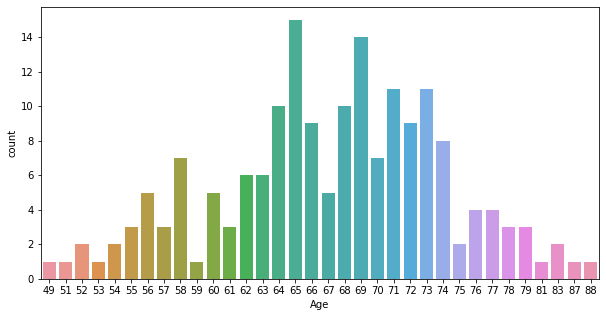

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(x='Age', data=unique_patient_df)

The age variable doesn't seem to be particularly informative, it follows a Normal/Gaussian distribution.

**Sex**

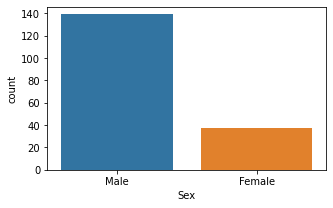

In [6]:
plt.figure(figsize=(5,3))
sns.countplot(x='Sex', data=unique_patient_df)

There is a clear unbalance in the patients sex; assuming this imbalance is also present in the test set and isn't a result of random sampling (Do males have a higher probability of getting sick ?), it could be important to check the correlation with the FVC Progression values.

**Smoking Status**

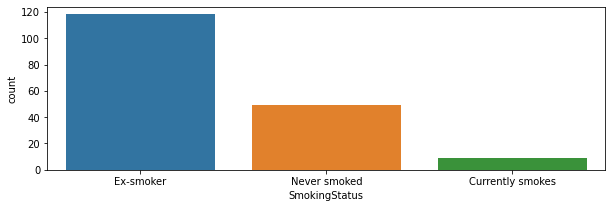

In [7]:
plt.figure(figsize=(10, 3))
sns.countplot(x='SmokingStatus', data=unique_patient_df)

Again, there is some imbalance between the different "Smoking Status" categories, it may be worthwhile to check the presence of any correlation with the target variable.

**Weeks (# of visits per patient)**

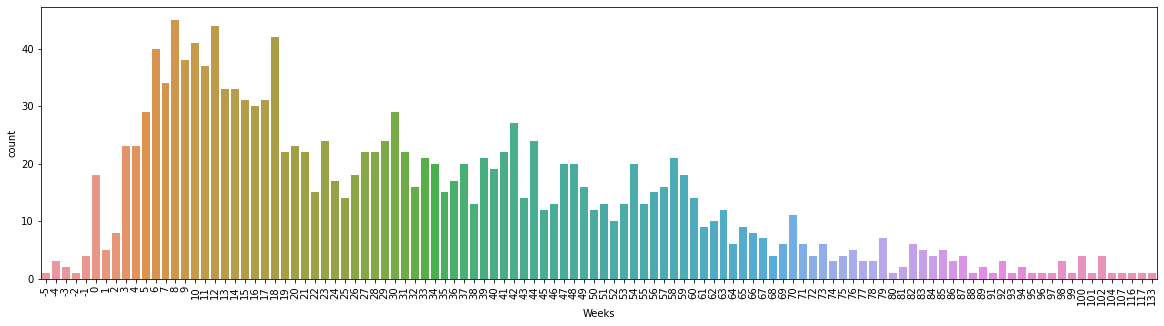

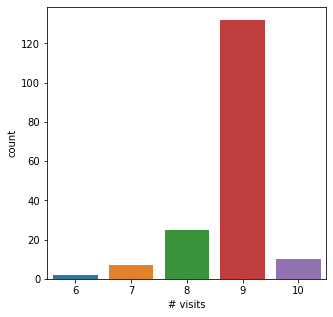

In [8]:
plt.figure(figsize=(20, 5))
ax = sns.countplot(x='Weeks', data=train_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

plt.figure(figsize=(5, 5))
sns.countplot(x='# visits', data=unique_patient_df)

From the "Weeks" attribute one can see: 
* The necessary values for the prediction stage, from week -12 to 133
* The visits become increasingly rare the more time passes from the CT scan
* The majority of patients has been subjected to an average of 9 medical visits.

# 1.2 Continuous features

**FVC**

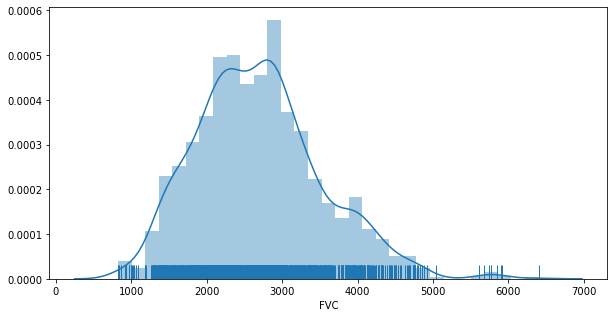

In [9]:
plt.figure(figsize=(10, 5))
sns.distplot(train_df['FVC'], rug=True)

**Percent**

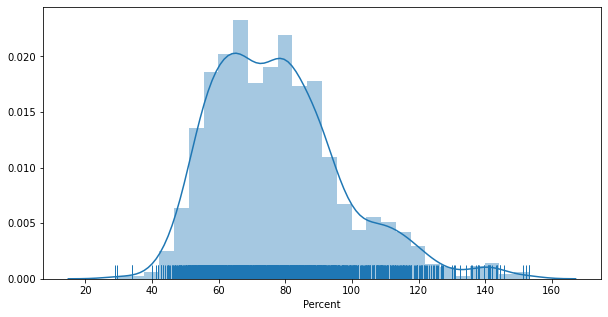

In [10]:
plt.figure(figsize=(10, 5))
sns.distplot(train_df['Percent'], rug=True)

Both "FVC" and "Percent" seem to roughly follow a Gaussian distribution with a light skew to the left.

**Expected FVC**

The following two variables represents the actual FVC values represented in the dataset by the "Percent" variable and their difference.
Interestingly, there are a couple patients where Percent is over 100%, meaning the measured FVC is higher than what it's supposed to be.

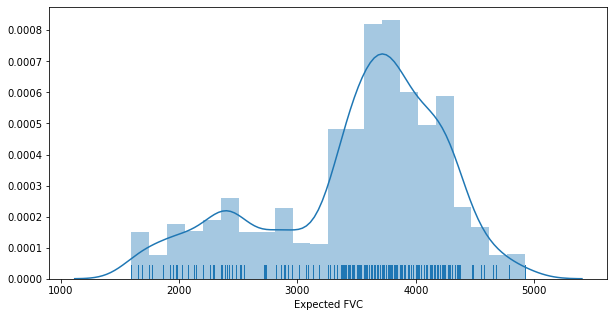

In [11]:
train_df['Expected FVC'] = train_df['FVC'] * (100/train_df['Percent'])

plt.figure(figsize=(10, 5))
sns.distplot(train_df['Expected FVC'], rug=True)

**FVC Difference**

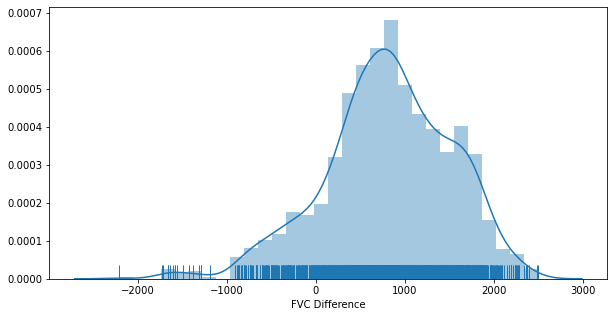

In [12]:
train_df['FVC Difference'] = train_df['Expected FVC'] - train_df['FVC']

plt.figure(figsize=(10, 5))
sns.distplot(train_df['FVC Difference'], rug=True)

# 2 - Feature Interaction Analysis

Here we'll check the possible relationship between variables.

**Clinical Data contingency table**

Let's start by checking the composition of our dataset, by Sex and Smoking Status.
The majority (60%) is composed by males (has we have seen before) ex-smokers (the most represented category.)

In [13]:
pd.crosstab(train_df.Sex, train_df.SmokingStatus, margins=True, normalize=True)

SmokingStatus,Currently smokes,Ex-smoker,Never smoked,All
Sex,,,,
Female,0.011620,0.069077,0.129116,0.209813
Male,0.041317,0.601033,0.147837,0.790187
All,0.052937,0.670110,0.276953,1.000000


There doesn't seem to be any particular correlation between the categorical variables.
The continous variables exhibit a clear positive correlation, between "FVC" and "Percent", while the new engineered feature FVC Difference has an almost perfect negative correlation with Percent.

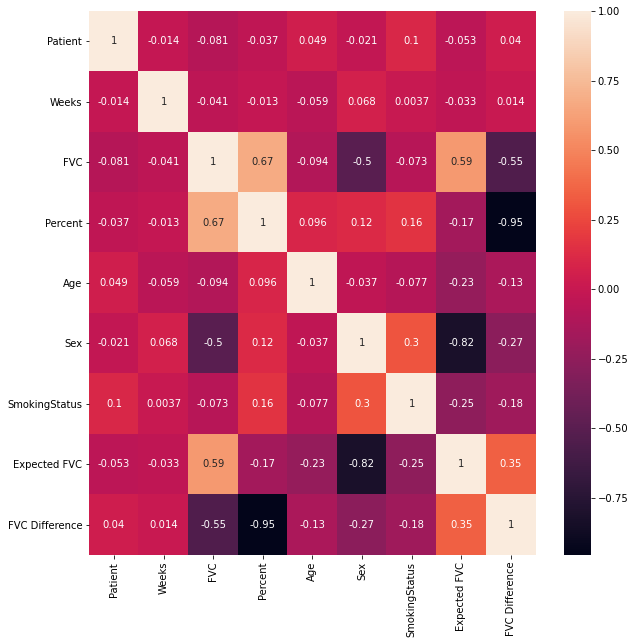

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(train_df.apply(lambda x : pd.factorize(x)[0] if x.dtype=='object' else x).corr(method='pearson'),
            annot=True)

The following interactive charts show the Pulmonary Capacity decline  by Patient, Sex, and Smoking Status.
In each of them clicking on the legend will show only the corresponding plot, double-clicking will hide/show all the lines.

**Actual/Expected FVC Progression by Patient**

In [15]:
fig = px.line(train_df, 'Weeks', 'FVC', color='Patient',
             title='Pulmonary Condition Progression by Patient',
             labels={'Week':'Week #',
                     'FVC' : 'Actual\Expected FVC'})
fig.update_traces(mode='lines+markers')

for i in fig.data:
    new_element = go.Scattergl(i)
    new_element['mode'] = 'markers'
    new_element['name'] = i['name'] + '_EX'
    new_element['y'] = train_df.loc[train_df['Patient'] == new_element['legendgroup']]['Expected FVC']
    fig.add_trace(new_element)


fig.show()

**FVC Progression by Sex**

In [16]:
fig = px.line(train_df, 'Weeks', 'FVC', line_group='Patient', color='Sex',
             title='Pulmonary Condition Progression by Sex')
fig.update_traces(mode='lines+markers')

**FVC Progression by SmokingStatus**

In [17]:
fig = px.line(train_df, 'Weeks', 'FVC', line_group='Patient', color='SmokingStatus',
             title='Pulmonary Condition Progression by Sex')
fig.update_traces(mode='lines+markers')

Partitioning the patients by Sex seems to show that female patients occupy a smaller range of FVC values, as does partitioning by SmokingStatus for people currently smoking, but we have to remember that those are the two most under-represented categories in the dataset, so these may just be faulty assumptions.

# 3 - CT Scan Features 

In this section I'll explore the DICOM files representing the CT Lung Scans for the patients, how to load and process them, and how to extract some additional features.

For an even more informative explanation, you can visit the Radiology Data Quest blog (https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/), from where I learned the tools used in the rest of this notebook and which I thank for their public explanation.

It's also necessary to thank Kaggle user Dr.Sàndor Kónya (@sandorkonya) for his wonderful Domain Expert Insights, which can be found here (Part 1: https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/165727, Part 2: https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/discussion/166123).

In [18]:
import pydicom
from glob import glob
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.filters import threshold_otsu, median
from scipy.ndimage import binary_fill_holes
from skimage.segmentation import clear_border
from scipy.stats import describe

Let's check the scans for the first patient.

In [19]:
patient_dir = '../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/'
scans = glob(patient_dir + '/*.dcm')

scans[:5]

['../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/18.dcm',
 '../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/10.dcm',
 '../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/30.dcm',
 '../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/16.dcm',
 '../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/21.dcm']

Let's define some helper functions to load, sort and process the images.

In [20]:
def load_scan(path):
    scans = os.listdir(path)
    slices = []
    
    for scan in scans:
        with pydicom.dcmread(path + '/' + scan) as s:
            slices.append(s)
    
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        except:
            slice_thickness = slices[0].SliceThickness
    
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image <= -1000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

(-0.5, 511.5, 511.5, -0.5)

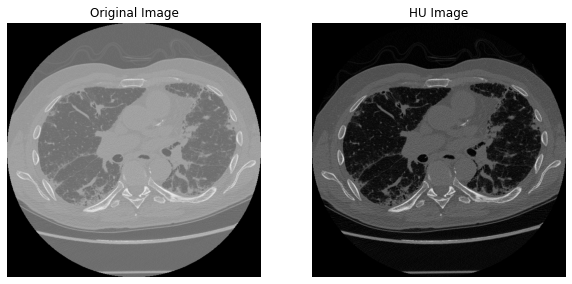

In [21]:
patient = load_scan(patient_dir)
imgs = get_pixels_hu(patient)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].set_title('Original Image')
ax[0].imshow(patient[15].pixel_array, cmap='gray')
ax[0].axis('off')

ax[1].set_title('HU Image')
ax[1].imshow(imgs[15], cmap='gray')
ax[1].axis('off')

Let's have a look at the distribution of pixels in the images converted to Hounsfield Units.

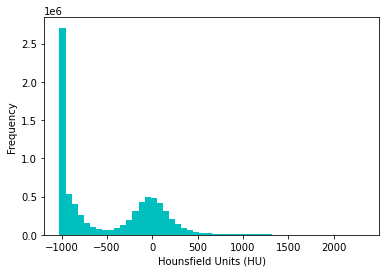

In [22]:
plt.hist(imgs.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

Checking with the HU table shows: 
* There is a lot of air, the peak around -1000
* At around -500 there are some pixels classified as Lung;
* The smaller gaussian-shaped peak at 0 indicates soft tissues;
* The distribution tail from 700 onward shows the presence of bones.

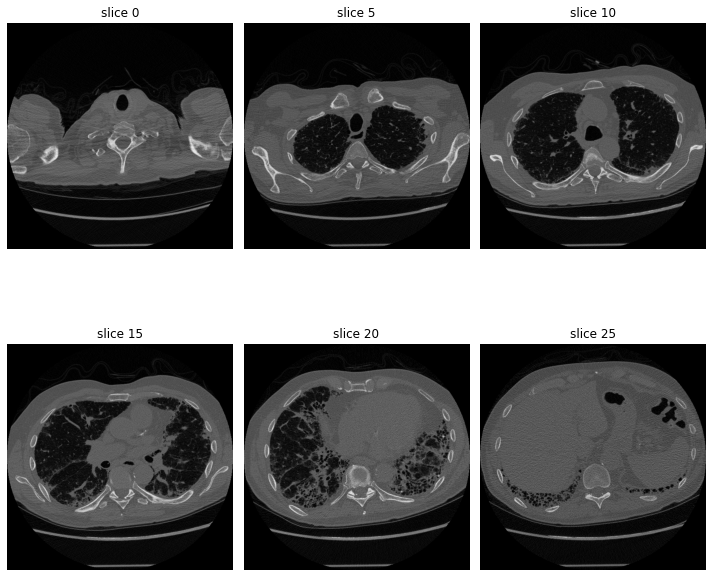

In [23]:
def sample_stack(stack, rows=2, cols=3, start_with=0, show_every=5):
    fig,ax = plt.subplots(rows,cols,figsize=[10,10])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[i // (rows+1), int(i % cols)].set_title('slice %d' % ind)
        ax[i // (rows+1), int(i % cols)].imshow(stack[ind],cmap='gray')
        ax[i // (rows+1), int(i % cols)].axis('off')
    plt.tight_layout()
    plt.show()

sample_stack(imgs)

Now let's try to segment the lungs from the scan.

In [24]:
def lung_segment(img, display=False):
    thresh = threshold_otsu(img)
    binary = img <= thresh

    lungs = median(clear_border(binary))
    lungs = morphology.binary_closing(lungs, selem=morphology.disk(7))
    lungs = binary_fill_holes(lungs)

    final = lungs*img
    final[final == 0] = np.min(img)
    
    if display:
        fig, ax = plt.subplots(1, 4, figsize=(15, 15))

        ax[0].set_title('HU Image')
        ax[0].imshow(img, cmap='gray')
        ax[0].axis('off')

        ax[1].set_title('Thresholded Image')
        ax[1].imshow(binary, cmap='gray')
        ax[1].axis('off')

        ax[2].set_title('Lungs Mask')
        ax[2].imshow(lungs, cmap='gray')
        ax[2].axis('off')

        ax[3].set_title('Final Image')
        ax[3].imshow(final, cmap='gray')
        ax[3].axis('off')
    
    return final, lungs

def lung_segment_stack(imgs):
    
    masks = np.empty_like(imgs)
    segments = np.empty_like(imgs)
    
    for i, img in enumerate(imgs):
        seg, mask = lung_segment(img)
        segments[i,:,:] = seg
        masks[i,:,:] = mask
        
    return segments, masks

(array([[-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        ...,
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024],
        [-1024, -1024, -1024, ..., -1024, -1024, -1024]], dtype=int16),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]))

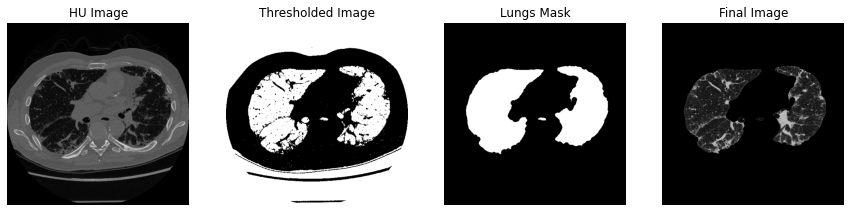

In [25]:
lung_segment(imgs[15], display=True)

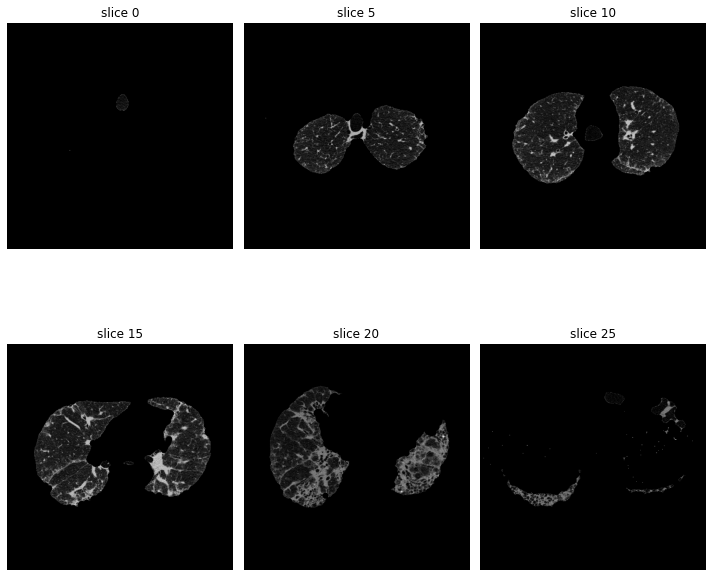

In [26]:
segmented, masks = lung_segment_stack(imgs)
sample_stack(segmented)

**Lung Volume/Total Lung Capacity Estimation**

In [27]:
def lung_volume(patient, masks):
    slice_thickness = patient[0].SliceThickness
    pixel_spacing = patient[0].PixelSpacing
    
    return np.round(np.sum(masks) * slice_thickness * pixel_spacing[0] * pixel_spacing[1], 3)

In [28]:
lung_vol = lung_volume(patient, masks)
print('Lung Volume is: ' + str(lung_vol) + ' mm^3 (' + str(lung_vol/1e6) + ' liters)')

Lung Volume is: 3755583.383 mm^3 (3.755583383 liters)


According to Wikipedia the average lung capacity for an adult is about 6 litres of air (6 millions mm^3); for this particular patient we got almost 4 liters, which is probably expected due to his pulmonary condition and the imperfect segmentation.

**Histogram Analysis**

In [29]:
def hist_analysis(segmented, display=False):
    values = segmented.flatten()
    values = values[values >= -1000]
    
    if display:
        plt.hist(values, bins=50)
    
    summary_statistics = describe(values)
    
    return summary_statistics

Mean is: -674.2804196262109
Variance is: 81213.70692811374
Skewness is: 1.3996160763909031
Kurtosis is: 1.395427332602539


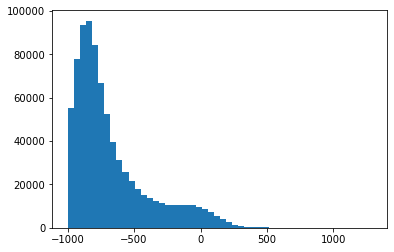

In [30]:
h_stat = hist_analysis(segmented, display=True)

print('Mean is: ' + str(h_stat.mean))
print('Variance is: ' + str(h_stat.variance))
print('Skewness is: ' + str(h_stat.skewness))
print('Kurtosis is: ' + str(h_stat.kurtosis))

**Lung Area/Diameter/Circumference**

In [31]:
def chest_measurements(patient, masks):
    middle_slice = masks[len(masks)//2]
    pixel_spacing = patient[0].PixelSpacing
    
    lung_area = np.round(np.sum(middle_slice.flatten()) * pixel_spacing[0] * pixel_spacing[1], 3)
    
    conv_h = morphology.convex_hull_image(middle_slice)
    props = measure.regionprops(measure.label(conv_h))
    
    chest_diameter = np.round(props[0].major_axis_length, 3)
    chest_circ = np.round(props[0].perimeter, 3)
    
    return lung_area, chest_diameter, chest_circ

In [32]:
ch_measure = chest_measurements(patient, masks)
print('Lung Area is: ' + str(ch_measure[0]) + ' mm^2')
print('Chest Diameter estimate is: ' + str(ch_measure[1]) + ' mm')
print('Chest Circumference estimate is: ' + str(ch_measure[2]) + ' mm')

Lung Area is: 21963.626 mm^2
Chest Diameter estimate is: 417.978 mm
Chest Circumference estimate is: 1122.95 mm


I'll remove the patients with codes **ID00011637202177653955184** and **ID00052637202186188008618**, because they cause errors when trying to read the DICOM files.

In [33]:
#augmented_df = train_df.drop(train_df.loc[train_df['Patient'].isin(['ID00011637202177653955184', #
#                                                                    'ID00052637202186188008618'])]
#                             .index).reset_index(drop=True)

Now let's compute these features for each patient and check the new correlation matrix.

**The kernel crashes with an out-of-memory error here because the size of the scans size and a probable memory leak in DICOM scans loading; the engineered features may be useful, but impossible to compute on a kernel for all data points.
If someone knows how to solve this please write it in the comments.**

In [34]:
#augmented_df['LungVolume'] = None
#augmented_df['Mean'] = None
#augmented_df['Variance'] = None
#augmented_df['Skewness'] = None
#augmented_df['Kurtosis'] = None
#augmented_df['LungArea'] = None
#augmented_df['ChestDiameter'] = None
#augmented_df['ChestCircumference'] = None

#for pid in augmented_df['Patient'].unique():
#    patient_dir = '../input/osic-pulmonary-fibrosis-progression/train/' + pid
#    patient = load_scan(patient_dir)
#    scans = get_pixels_hu(patient)
    
#    segmented, masks = lung_segment_stack(scans)
    
#    augmented_df.loc[augmented_df['Patient'] == pid, 'LungVolume'] = lung_volume(patient, masks)
    
#    hist_stats = hist_analysis(segmented)
#    augmented_df.loc[augmented_df['Patient'] == pid, 'Mean'] = np.round(hist_stats.mean, 3)
#    augmented_df.loc[augmented_df['Patient'] == pid, 'Variance'] = np.round(hist_stats.variance, 3)
#    augmented_df.loc[augmented_df['Patient'] == pid, 'Skewness'] = np.round(hist_stats.skewness, 3)
#    augmented_df.loc[augmented_df['Patient'] == pid, 'Kurtosis'] = np.round(hist_stats.kurtosis, 3)
    
#    chest_stat = chest_measurements(patient, masks)
#    augmented_df.loc[augmented_df['Patient'] == pid, 'LungArea'] = chest_stat[0]
#    augmented_df.loc[augmented_df['Patient'] == pid, 'ChestDiameter'] = chest_stat[1]
#    augmented_df.loc[augmented_df['Patient'] == pid, 'ChestCircumference'] = chest_stat[2]

In [35]:
#plt.figure(figsize=(13,13))
#sns.heatmap(augmented_df.apply(lambda x : pd.factorize(x)[0] if x.dtype=='object' else x).corr(method='pearson'),
#            annot=True)